# Western US Bootstrap test

##### Toy code to emulate bootstrapping of forest mortality satellite data analysis in Western US, paired with statistical tests for comparison of statistical significance
##### NOTE: This notebook example shows the sensitivity of the bootstrap tests to the size of random samples. A companion notebook (01_toy_bootstrap_NumRepititions_sensitivity.ipynb) shows the sensitivity of the bootstrap tests to number of bootstrap repititions.


## Generate data

For this simulation, let's assume we have two sample groups which are designed to be from the same distribution (that is, their means should be equal as well as their distributions). We'll test for the sample size at which we start to see an artificial difference between the two groups.


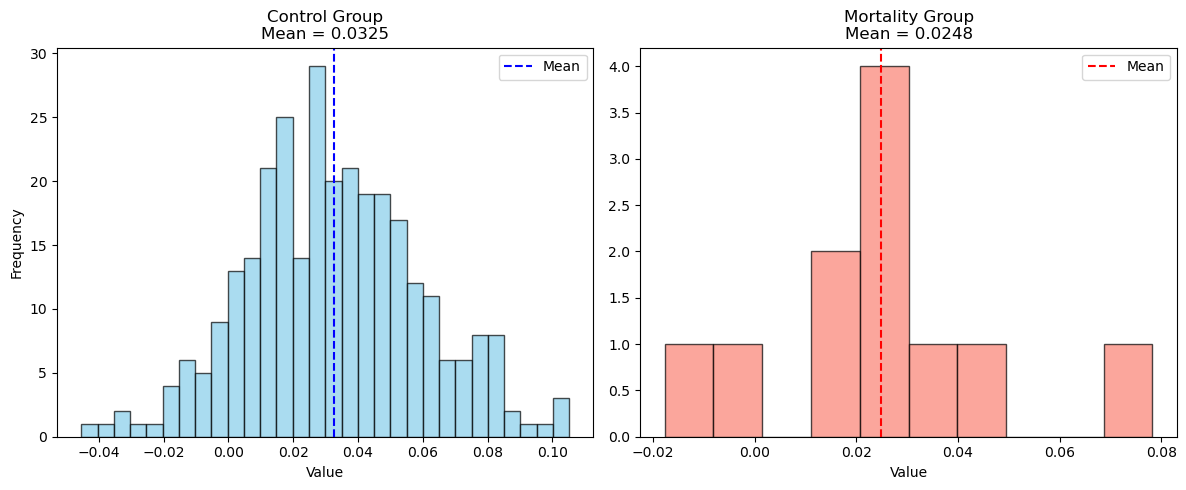

In [16]:
# Import relevant packages
import numpy as np
from numpy import random
import pandas as pd
import matplotlib.pyplot as plt

### MAIN PARAMETERS:
MORT_MEAN = 0.03127 # taken from real TROPOMI SIF mean & distr
MORT_STD = 0.02628 # taken from real TROPOMI SIF mean & distr
MORT_n = 11 # approx sample size of mortality pixels for 2022
CTRL_MEAN = 0.03127 # match mortality mean
CTRL_STD = 0.02628 # match mortality std dev
CTRL_n = 300 # approx sample size of control pixels

# Create a RandomState instance with a specific seed
seed_ctrl = 3
seed_mort = 3

### make 2 random variables with normal distributions, differing means and variances
# Generate random numbers for the control group
rng_ctrl = np.random.RandomState(seed_ctrl)
ctrl = rng_ctrl.normal(CTRL_MEAN, CTRL_STD, CTRL_n)

# Generate random numbers for the mortality group
rng_mort = np.random.RandomState(seed_mort)
mort = rng_mort.normal(MORT_MEAN, MORT_STD, MORT_n)

# Calculate means
mean_ctrl = np.mean(ctrl)
mean_mort = np.mean(mort)
actual_mean = mean_mort - mean_ctrl


# Plot side-by-side histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

# Plot ctrl histogram
axes[0].hist(ctrl, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(mean_ctrl, color='blue', linestyle='dashed', linewidth=1.5, label=f'Mean')
axes[0].set_title(f'Control Group\nMean = {mean_ctrl:.4f}')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Plot mort histogram
axes[1].hist(mort, bins=10, color='salmon', edgecolor='black', alpha=0.7)
axes[1].axvline(mean_mort, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean')
axes[1].set_title(f'Mortality Group\nMean = {mean_mort:.4f}')
axes[1].set_xlabel('Value')
axes[1].legend()

# Display plot
plt.tight_layout()
plt.show()



# Statistical tests

0. Bootstrap confidence intervals
   - The standard utility of bootstrapping is to estimate the confidence intervals of a statistic (in this case, the difference in means between two groups)
   - Non-parametric (does not assume normality of data or equal variances in groups)

To complement the confidence intervals, we can also perform statistical tests between each repition of sample selection to test whether those means and distributions are different.
1. Student's t-test
   - A basic way to test the differences between groups to see if they are different from 0
   - Assumes normality of data and equal variances in groups __(likely not the case in all our comparisons)__

2. Analysis of Variance (ANOVA)
   - Basically a t-test, but can be used for 2 or more groups
   - This is what we've using to compare Mortality and Control up until now
   - Assumes normality of data and equal variances in groups __(likely not the case in all our comparisons)__

3. Mann-Whitney U test
   - Non-parametric test for comparing the "central tendency" of two independent samples (i.e., medians)
   - Does not assume normality of data or equal variances in groups
   - __sample sizes of groups do NOT have to be equal__

4. Wilcoxon signed-rank test
   - Non-parametric test for comparing two paired samples (i.e. this mortality pixel is paired with a similar control pixel, etc)
   - Does not assume normality of data or equal variances in groups
   - __sample sizes of groups MUST be equal__

5. Kolmogorov-Smirnov test
   - Non-parametric test for comparing two independent samples with continuous distributions
   - Does not assume normality of data or equal variances in groups
   - __sample sizes of groups do NOT have to be equal__




## Sensitivity test - sample size

We will define two variables, _a_ and _b_, where
_a_ = number of bootstrap repetitions, and
_b_ = sample size of each random draw with replacement.

Let's perform a suite of statistical tests within the bootstrapping to compare sensitivity to _b_, the sample size of each bootstrap sample.

For this first test, we will set the number of repititions equal to 1000.

In [20]:
# Load stats packages
from scipy.stats import ttest_1samp
from scipy.stats import f_oneway
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
from scipy.stats import ks_2samp

# Set up empty arrays to store the MEAN confidence intervals and MEAN p-values for each value of b
conf_int_low_arr = []
conf_int_high_arr = []
mean_diff_arr = []

mean_p_values_ttest_arr = []
mean_p_values_ANOVA_arr = []
mean_p_values_mannwhitney_arr = []
mean_p_values_wilcoxon_arr = []
mean_p_values_ks_arr = []

# Values for b (sample size)
b_values = [3, 4, 5, 8, 11, 15, 20, 25, 30, 50, 75, 100, 150, 200, 300, 400, 500]
a = 1000

# Loop over the different values of b
for b in b_values:

   print(f'b = {b}')

   # Step 2: Manual bootstrap resampling with diff_means function

   # set up arrays to store resampled differences and p-values
   resampled_mean_diffs_arr = []
   p_values_ttest_arr = []
   p_values_ANOVA_arr = []
   p_values_mannwhitney_arr = []
   p_values_wilcoxon_arr = []
   p_values_ks_arr = []

   # Loop over the number of bootstrap samples
   for _ in range(a):
      # Resample independently with replacement
      resampled_mort = np.random.choice(mort, size=b, replace=True)
      resampled_ctrl = np.random.choice(ctrl, size=b, replace=True)
      resampled_diffs = resampled_mort - resampled_ctrl

      # Calculate difference in means for resampled data
      resampled_mean_diffs_arr.append(np.mean(resampled_mort) - np.mean(resampled_ctrl))
      
      ### Perform statistical tests on resampled Mortality and Control data
      # Student's t-test (are diffs different from 0?)
      t,p = ttest_1samp(resampled_diffs, 0) 
      p_values_ttest_arr.append(p)

      # ANOVA (are means different?)
      f,p = f_oneway(resampled_ctrl, resampled_mort)
      p_values_ANOVA_arr.append(p)

      # Mann-Whitney U test (are distributions different?)
      u,p = mannwhitneyu(resampled_ctrl, resampled_mort)
      p_values_mannwhitney_arr.append(p)

      # Wilcoxon signed-rank test (is one distribution greater than the other?)
      w,p = wilcoxon(resampled_ctrl, resampled_mort)
      p_values_wilcoxon_arr.append(p)

      # Kolmogorov-Smirnov test (are distributions different?)
      d,p = ks_2samp(resampled_ctrl, resampled_mort)
      p_values_ks_arr.append(p)


   # Convert to numpy array for easy manipulation
   resampled_mean_diffs_arr = np.array(resampled_mean_diffs_arr)
   p_values_ttest_arr = np.array(p_values_ttest_arr)
   p_values_ANOVA_arr = np.array(p_values_ANOVA_arr)
   p_values_mannwhitney_arr = np.array(p_values_mannwhitney_arr)
   p_values_wilcoxon_arr = np.array(p_values_wilcoxon_arr)
   p_values_ks_arr = np.array(p_values_ks_arr)
   
   # Step 3: Calculate confidence interval
   conf_level = 0.95
   lower_percentile = (1 - conf_level) / 2 * 100
   upper_percentile = (1 + conf_level) / 2 * 100
   ci_lower, ci_upper = np.percentile(resampled_mean_diffs_arr, [lower_percentile, upper_percentile])

   # Step 4: Calculate mean p-values from the statistical tests
   mean_p_ttest_arr = np.mean(p_values_ttest_arr)
   mean_p_ANOVA_arr = np.mean(p_values_ANOVA_arr)
   mean_p_mannwhitney_arr = np.mean(p_values_mannwhitney_arr)
   mean_p_wilcoxon_arr = np.mean(p_values_wilcoxon_arr)
   mean_p_ks_arr = np.mean(p_values_ks_arr)

   # Store the confidence interval values for plotting
   conf_int_low_arr.append(ci_lower)
   conf_int_high_arr.append(ci_upper)
   mean_diff_arr.append(np.mean(resampled_mean_diffs_arr))

   # Store the p values for plotting
   mean_p_values_ttest_arr.append(mean_p_ttest_arr)
   mean_p_values_ANOVA_arr.append(mean_p_ANOVA_arr)
   mean_p_values_mannwhitney_arr.append(mean_p_mannwhitney_arr)
   mean_p_values_wilcoxon_arr.append(mean_p_wilcoxon_arr)
   mean_p_values_ks_arr.append(mean_p_ks_arr)
   
   # end loop

print('done')



b = 3


/uufs/chpc.utah.edu/common/home/u6017162/software/pkg/miniforge3/envs/main/lib/python3.12/site-packages/scipy/stats/_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


b = 4
b = 5
b = 8
b = 11
b = 15
b = 20
b = 25
b = 30
b = 50
b = 75
b = 100
b = 150
b = 200
b = 300
b = 400
b = 500
done


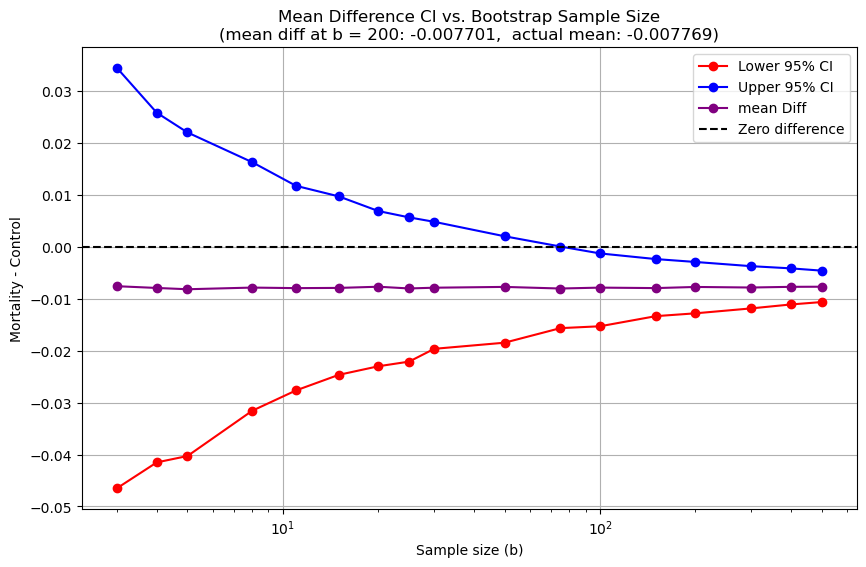

In [21]:

# Plot the confidence intervals as a function of b
plt.figure(figsize=(10, 6))
plt.plot(b_values, conf_int_low_arr, label='Lower 95% CI', color='red', marker='o')
plt.plot(b_values, conf_int_high_arr, label='Upper 95% CI', color='blue', marker='o')
plt.plot(b_values, mean_diff_arr, label='mean Diff', color='purple', marker='o')
plt.axhline(0, linestyle = '--', color = 'black', label='Zero difference')
plt.xscale('log')  # Use a logarithmic scale for better visualization
plt.xlabel('Sample size (b)')
plt.ylabel('Mortality - Control')
plt.title(f'Mean Difference CI vs. Bootstrap Sample Size\n(mean diff at b = 200: {mean_diff_arr[-1]:3f},  actual mean: {actual_mean:3f})')
plt.legend()
plt.grid(True)
plt.show()


#### NOTE:
A confidence interval which includes zero (denoted by the black dashed line) indicates that we do not have confidence that the difference in means is statistically different from 0.
i.e. We cannot reject the null hypothesis that the Mortality and Control samples could have been drawn from the same population distribution.

The opposite is true when a confidence interval does NOT include zero. 

Here we don't expect the distributions to differ by chance alone, so sampling __more than ~20 samples is giving us artificial confidence that the means are different.__



#### Sensitivity of p-values to sample size

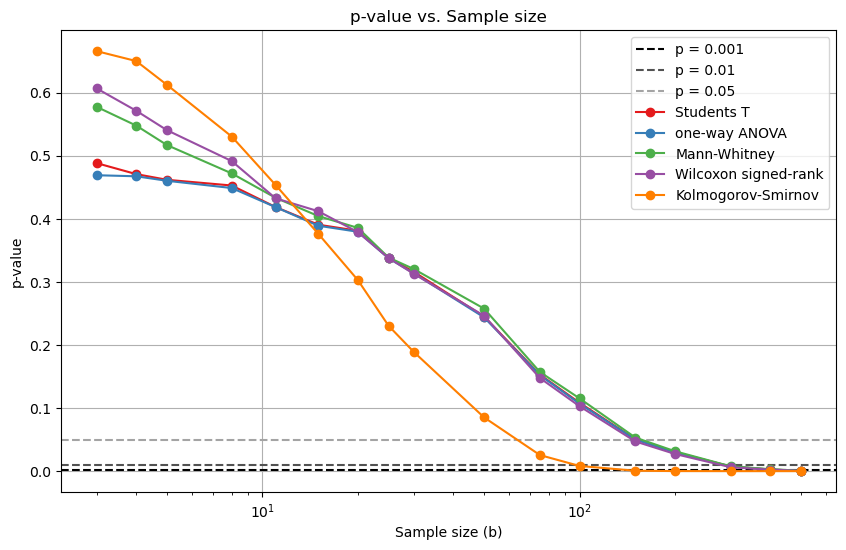

In [22]:
# Plot the p_value as a function of b
plt.figure(figsize=(10, 6))
plt.axhline(0.001, linestyle = '--', color = 'black', label='p = 0.001')
plt.axhline(0.01, linestyle = '--', color = '#525252', label='p = 0.01')
plt.axhline(0.05, linestyle = '--', color = '#a4a4a4', label='p = 0.05')
plt.plot(b_values, mean_p_values_ttest_arr, label='Students T', color='#e41a1c', marker='o')
plt.plot(b_values, mean_p_values_ANOVA_arr, label='one-way ANOVA', color='#377eb8', marker='o') 
plt.plot(b_values, mean_p_values_mannwhitney_arr, label='Mann-Whitney', color='#4daf4a', marker='o')
plt.plot(b_values, mean_p_values_wilcoxon_arr, label='Wilcoxon signed-rank', color='#984ea3', marker='o')
plt.plot(b_values, mean_p_values_ks_arr, label='Kolmogorov-Smirnov', color='#ff7f00', marker='o')
plt.xscale('log')  # Use a logarithmic scale for better visualization
plt.xlabel('Sample size (b)')
plt.ylabel('p-value')
plt.title(f'p-value vs. Sample size')
plt.legend()
plt.grid(True)
plt.show()

__Regardless of the statistical test used, resampling with larger sample sizes greatly reduces the p-value below 0.05, even though the samples are drawn from the same distribution.__

# Sensitivity test - sampling with unequal sample sizes between groups

For two of the non-parametric statistical tests (Mann-Whitney, Kolmogorov-Smirnov), we do NOT need to have equal sample sizes between the mortality and control groups. Should we be resampling from each sample using a sample size equal to the original sample? Let's see what happens to the confidence intervals and p-values when we resample using the total size of each respective sample group.

We will vary the number of repititions (_a_) while fixing the sample size of each random draw with replacement (_b_) to 300 for control and 11 for mortality.

In [17]:
# Set up empty arrays to store the MEAN confidence intervals and MEAN p-values for each value of a
conf_int_low_arr = []
conf_int_high_arr = []
mean_diff_arr = []

mean_p_values_mannwhitney_arr = []
mean_p_values_ks_arr = []

a_values = [10, 20, 30, 50, 100, 250, 500, 1000, 2000, 3000, 5000, 10000]

# Loop over the different values of a
for a in a_values:

   print(f'a = {a}')

   # Step 2: Manual bootstrap resampling with diff_means function

   # set up arrays to store resampled differences and p-values (Mann-Whitney and Kolmogorov-Smirnov ONLY)
   resampled_mean_diffs_arr = []
   p_values_mannwhitney_arr = []
   p_values_ks_arr = []

   # Loop over the number of bootstrap samples
   for _ in range(a):
      # Resample independently with replacement
      resampled_mort = np.random.choice(mort, size=MORT_n, replace=True) # THIS TIME, USE THE TOTAL SIZE OF THE MORTALITY SAMPLE
      resampled_ctrl = np.random.choice(ctrl, size=CTRL_n, replace=True) # THIS TIME, USE THE TOTAL SIZE OF THE CONTROL SAMPLE

      # Calculate difference in means for resampled data
      resampled_mean_diffs_arr.append(np.mean(resampled_mort) - np.mean(resampled_ctrl))
      
      ### Perform statistical tests on resampled Mortality and Control data (Mann-Whitney and Kolmogorov-Smirnov ONLY)

      # Mann-Whitney U test (are distributions different?)
      u,p = mannwhitneyu(resampled_ctrl, resampled_mort)
      p_values_mannwhitney_arr.append(p)

      # Kolmogorov-Smirnov test (are distributions different?)
      d,p = ks_2samp(resampled_ctrl, resampled_mort)
      p_values_ks_arr.append(p)


   # Convert to numpy array for easy manipulation (Mann-Whitney and Kolmogorov-Smirnov ONLY)
   resampled_mean_diffs_arr = np.array(resampled_mean_diffs_arr)
   p_values_mannwhitney_arr = np.array(p_values_mannwhitney_arr)
   p_values_ks_arr = np.array(p_values_ks_arr)
   
   # Step 3: Calculate confidence interval
   conf_level = 0.95
   lower_percentile = (1 - conf_level) / 2 * 100
   upper_percentile = (1 + conf_level) / 2 * 100
   ci_lower, ci_upper = np.percentile(resampled_mean_diffs_arr, [lower_percentile, upper_percentile])

   # Step 4: Calculate mean p-values from the statistical tests (Mann-Whitney and Kolmogorov-Smirnov ONLY)
   mean_p_mannwhitney_arr = np.mean(p_values_mannwhitney_arr)
   mean_p_ks_arr = np.mean(p_values_ks_arr)

   # Store the confidence interval values for plotting
   conf_int_low_arr.append(ci_lower)
   conf_int_high_arr.append(ci_upper)
   mean_diff_arr.append(np.mean(resampled_mean_diffs_arr))

   # Store the p values for plotting (Mann-Whitney and Kolmogorov-Smirnov ONLY)
   mean_p_values_mannwhitney_arr.append(mean_p_mannwhitney_arr)
   mean_p_values_ks_arr.append(mean_p_ks_arr)
   
   # end loop

print('done')



a = 10
a = 20
a = 30
a = 50
a = 100
a = 250
a = 500
a = 1000
a = 2000
a = 3000
a = 5000
a = 10000
done


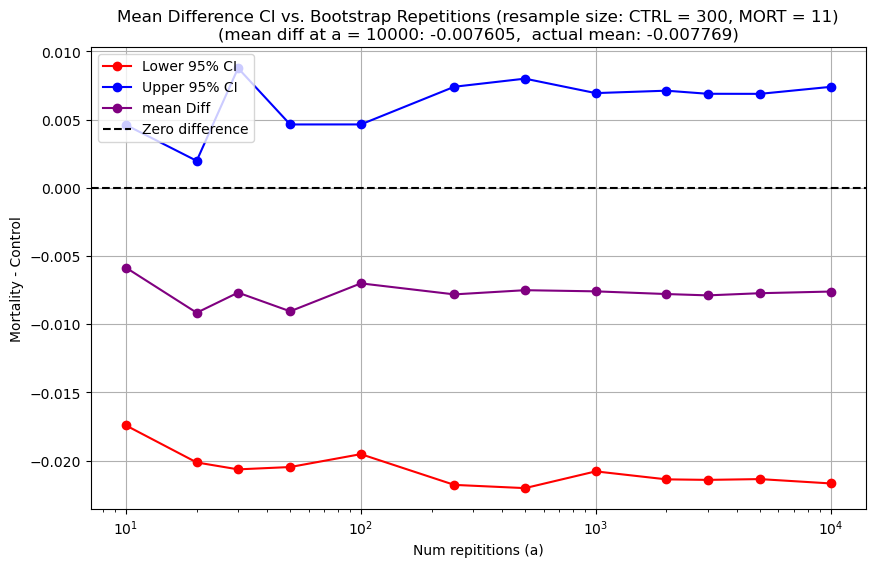

In [18]:
# Plot the confidence intervals as a function of a
plt.figure(figsize=(10, 6))
plt.plot(a_values, conf_int_low_arr, label='Lower 95% CI', color='red', marker='o')
plt.plot(a_values, conf_int_high_arr, label='Upper 95% CI', color='blue', marker='o')
plt.plot(a_values, mean_diff_arr, label='mean Diff', color='purple', marker='o')
plt.axhline(0, linestyle = '--', color = 'black', label='Zero difference')
plt.xscale('log')  # Use a logarithmic scale for better visualization
plt.xlabel('Num repititions (a)')
plt.ylabel('Mortality - Control')
plt.title(f'Mean Difference CI vs. Bootstrap Repetitions (resample size: CTRL = {CTRL_n}, MORT = {MORT_n})\n(mean diff at a = 10000: {mean_diff_arr[-1]:3f},  actual mean: {actual_mean:3f})')
plt.legend()
plt.grid(True)
plt.show()

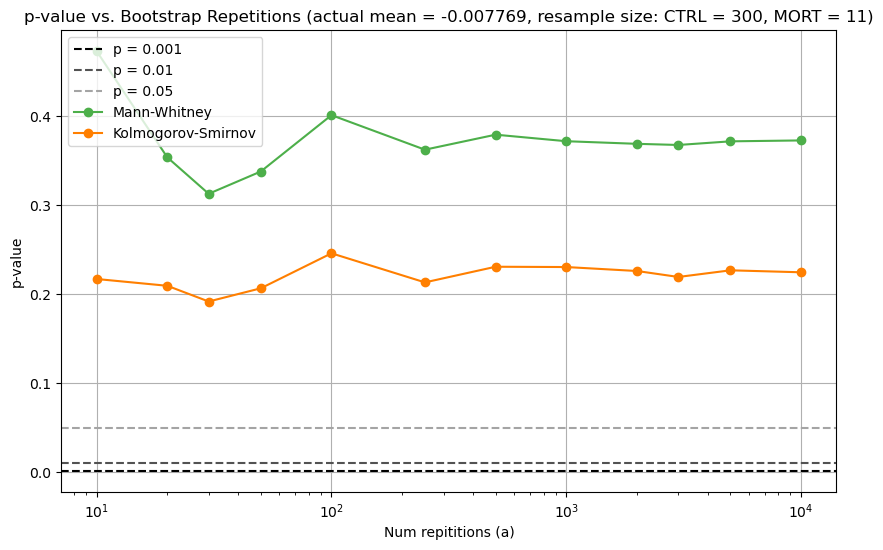

In [19]:
# Plot the p_value as a function of a
plt.figure(figsize=(10, 6))
plt.axhline(0.001, linestyle = '--', color = 'black', label='p = 0.001')
plt.axhline(0.01, linestyle = '--', color = '#525252', label='p = 0.01')
plt.axhline(0.05, linestyle = '--', color = '#a4a4a4', label='p = 0.05')
plt.plot(a_values, mean_p_values_mannwhitney_arr, label='Mann-Whitney', color='#4daf4a', marker='o')
plt.plot(a_values, mean_p_values_ks_arr, label='Kolmogorov-Smirnov', color='#ff7f00', marker='o')
plt.xscale('log')  # Use a logarithmic scale for better visualization
plt.xlabel('Num repititions (a)')
plt.ylabel('p-value')
plt.title(f'p-value vs. Bootstrap Repetitions (actual mean = {actual_mean:3f}, resample size: CTRL = {CTRL_n}, MORT = {MORT_n})')
plt.legend()
plt.grid(True)
plt.show()

Eventually we arrive at a confidence interval which includes 0, indicating that the samples could have been drawn from the same distribution (which is what we expect). The p values stabilize above 0.05 which is also what we'd expect these statistical tests to show us. But does that mean that we should be using the total sample size of each group when resampling?